In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from scipy.stats import norm
from sympy import Matrix

print(torch.cuda.is_available())

#torch.set_printoptions(sci_mode=False)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

False
cpu


In [2]:
def random_normale(nb_trajectoires, nb_steps, d):
    return torch.randn(nb_trajectoires, nb_steps+1, d) #simule des N(0,1) qui serviront à la construction des mouvements bronwiens

def printResults(basket_call, asian_option, digital_option, worst_of_put):
    print(f"Monte Carlo price pour Basket Call Option: {calcul_IC(basket_call)[0]:.2f} "
          f"({calcul_IC(basket_call)[1]:.2f}, "
          f"{calcul_IC(basket_call)[2]:.2f})")
    
    print(f"Monte Carlo price pour Asian Option: {calcul_IC(asian_option)[0]:.2f} "
          f"({calcul_IC(asian_option)[1]:.2f}, "
          f"{calcul_IC(asian_option)[2]:.2f})")
    
    print(f"Monte Carlo price pour Digital Option: {calcul_IC(digital_option)[0]:.2f} "
          f"({calcul_IC(digital_option)[1]:.2f}, "
          f"{calcul_IC(digital_option)[2]:.2f})")
    
    print(f"Monte Carlo price pour Worst Of Put Option: {calcul_IC(worst_of_put)[0]:.2f} "
          f"({calcul_IC(worst_of_put)[1]:.2f}, "
          f"{calcul_IC(worst_of_put)[2]:.2f})")

# Paramètres
S0 = 100.0
K = 100.0
T = torch.tensor(1.0)
r = torch.tensor(0.05)
sigma = 0.4
rho = 0.75
d = 10
nb_trajectoires = 30_000
nb_steps = 100
nbsj = 10
weights = 1/10#(torch.ones(d) / d)
G = 100

#for heston model
kappa = 2.0
sigma_0 = 0.04
a = 0.04
nu = 0.01
gamma = torch.tensor(-0.2)

In [3]:
#Les payoff de chaque option
def basket_call_payoff(S, weights, K):
  valeur_basket = torch.sum(weights* S[:, -1, :], dim=1)
  return torch.exp(-r*T)*torch.maximum(valeur_basket - K, torch.tensor(0.0))

def digital_option_payoff(S, weights, K):
  valeur_digitale = torch.sum(weights * S[:, -1, :], dim=1)
  return torch.exp(-r*T)*torch.where(valeur_digitale >= K, torch.tensor(1.0), torch.tensor(0.0)) * torch.tensor(G)

def asian_option_payoff(S, weights, K):
  asian_average = torch.mean(torch.sum(weights * S, axis=-1), axis=-1)
  return torch.maximum(asian_average - K, torch.tensor(0.0))*torch.exp(-r*T)

def worst_of_put_payoff(S, weights, K):
  valeur_worst = torch.min(S[:, -1, :], dim=1).values
  return torch.exp(-r*T)*torch.maximum(K - valeur_worst, torch.tensor(0.0))

### Black Scholes Model

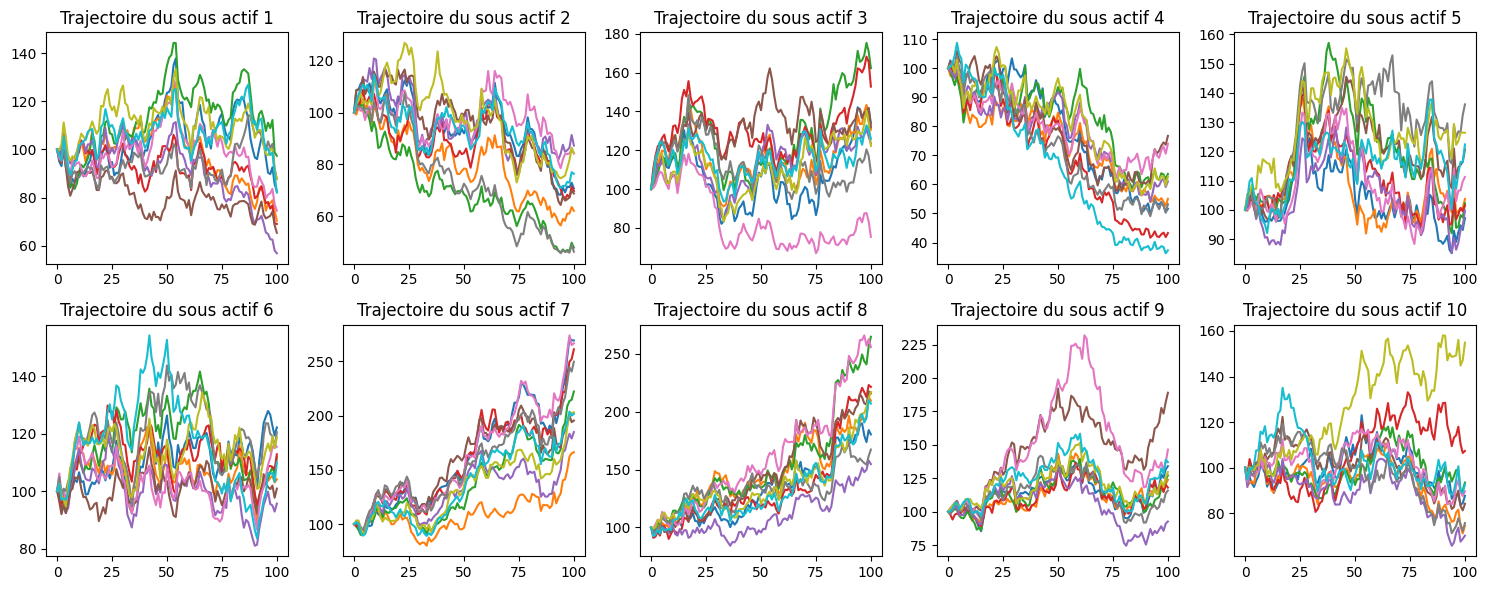

Monte Carlo price pour Basket Call Option: 16.30 (15.99, 16.61)
Monte Carlo price pour Asian Option: 9.10 (8.93, 9.26)
Monte Carlo price pour Digital Option: 46.15 (45.62, 46.69)
Monte Carlo price pour Worst Of Put Option: 26.65 (26.43, 26.87)


In [4]:
def black_scholes_mc(S0 , K, T, r, sigma, nb_trajectoires, nb_steps, d, rho, Z):
    dt = T / nb_steps
    Sigma = torch.full((d, d), rho) + (1 - rho) * torch.eye(d) #Matrice de corrélation
    L = torch.linalg.cholesky(Sigma)
    dW = torch.einsum('ijk,kl->ijl', Z, L.T)
    S = torch.zeros((Z.shape[0], Z.shape[1], Z.shape[2]))
    S[:, 0, :] =  S0
    for i in range(1, nb_steps + 1):
        S[:, i, :] = S[:, i-1, :]*torch.exp((r - 0.5 * sigma**2) * dt + torch.sqrt(dt) * sigma * dW[:,i-1,:])
    return S

S = black_scholes_mc(S0, K, T, r, sigma, nb_trajectoires, nb_steps, d, rho, random_normale(nb_trajectoires, nb_steps, d))

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

#On trace les différentes trajectoires du marché
for i, ax in enumerate(axes.flatten()):
    if i < nb_trajectoires:
        ax.plot(S[i, :, :])
        ax.set_title(f'Trajectoire du sous actif {i + 1}')

plt.tight_layout()
plt.show()

#On stocke les payoff de chaque option
basket_call = basket_call_payoff(S, weights, K)
asian_option = asian_option_payoff(S, weights, K)
digital_option = digital_option_payoff(S, weights, K)
worst_of_put = worst_of_put_payoff(S, weights, K)

def calcul_IC(prices):
    mean_price = torch.mean(prices)
    std_dev = torch.std(prices)
    n = len(prices)
    lower_bound = mean_price - 1.96 * (std_dev / np.sqrt(n))
    upper_bound = mean_price + 1.96 * (std_dev / np.sqrt(n))

    return mean_price, lower_bound, upper_bound

printResults(basket_call, asian_option, digital_option, worst_of_put)

### Local volatility Model

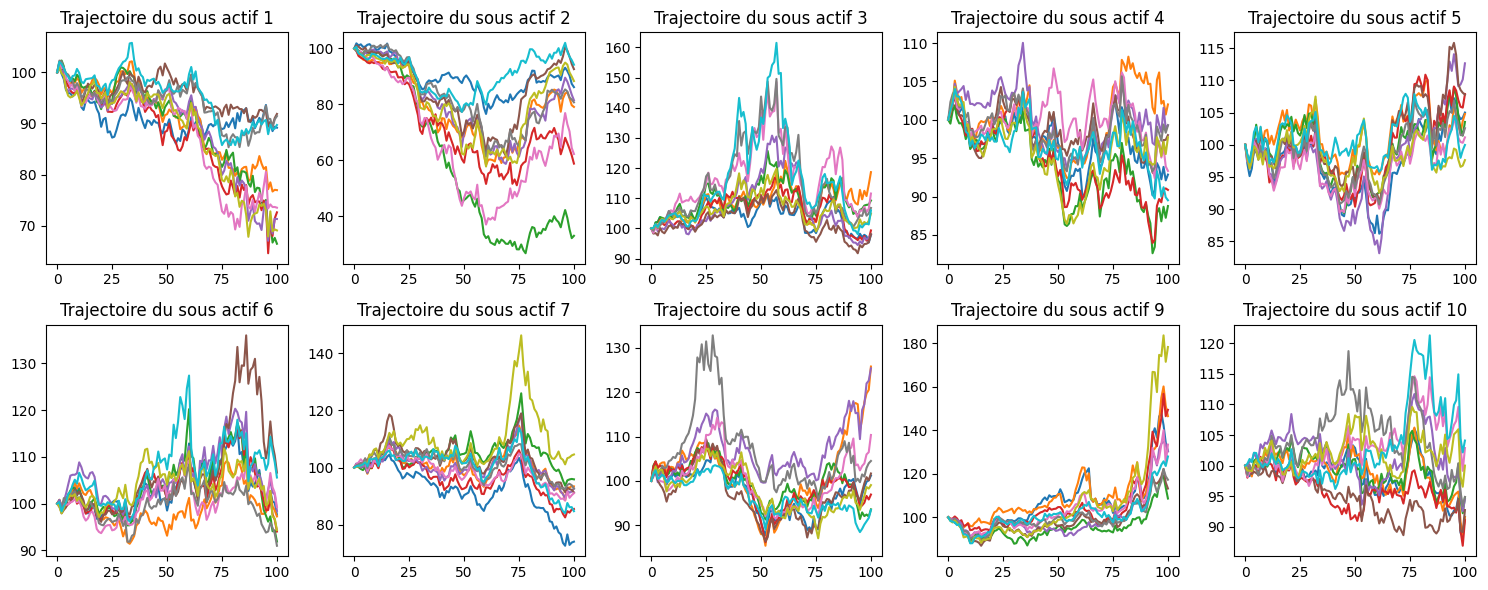

Monte Carlo price pour Basket Call Option: 8.88 (8.65, 9.11)
Monte Carlo price pour Asian Option: 4.20 (4.12, 4.29)
Monte Carlo price pour Digital Option: 48.45 (47.91, 48.99)
Monte Carlo price pour Worst Of Put Option: 10.83 (10.69, 10.97)


In [5]:
def volatilite_locale(S0, K, T, r, sigma, nb_trajectoires, nb_steps, d, rho, Z):
    dt = T / nb_steps
    Sigma = torch.full((d, d), rho) + (1 - rho) * torch.eye(d)
    L = torch.linalg.cholesky(Sigma)
    dW = torch.einsum('ijk,kl->ijl', Z, L.T)
    S = torch.zeros((Z.shape[0], Z.shape[1], Z.shape[2]))
    S[:, 0, :] =  S0
    
    for i in range(1, nb_steps + 1):
        t = i * dt
        vol_locale = 0.6 * (1.2 - torch.exp(-0.1 * t) * torch.exp(-0.001 * (S[:, i-1, :] * \
                            torch.exp(r*t) - S0)**2))* torch.exp(-0.05 * torch.sqrt(t))
        
        dSi = r * S[:, i-1, :] * dt + torch.sqrt(dt) * vol_locale * S[:, i-1, :] * dW[:, i-1, :]
        S[:, i, :] = S[:, i-1, :] + dSi
    return S

S_volatilite_locale = volatilite_locale(S0, K, T, r, sigma, nb_trajectoires, nb_steps, d, rho,random_normale(nb_trajectoires, nb_steps, d))

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

#On trace les différentes trajectoires du marché
for i, ax in enumerate(axes.flatten()):
    if i < nb_trajectoires:
        ax.plot(S_volatilite_locale[i, :, :])
        ax.set_title(f'Trajectoire du sous actif {i + 1}')

plt.tight_layout()
plt.show()

# Prix des différentes options avec volatilité locale
basket_call_vol = basket_call_payoff(S_volatilite_locale, weights, K)
asian_option_vol = asian_option_payoff(S_volatilite_locale, weights, K)
digital_option_vol = digital_option_payoff(S_volatilite_locale, weights, K)
worst_of_put_vol = worst_of_put_payoff(S_volatilite_locale, weights, K)
# Affichage des résultats avec intervalles de confiance de 95%

printResults(basket_call_vol, asian_option_vol, digital_option_vol, worst_of_put_vol)

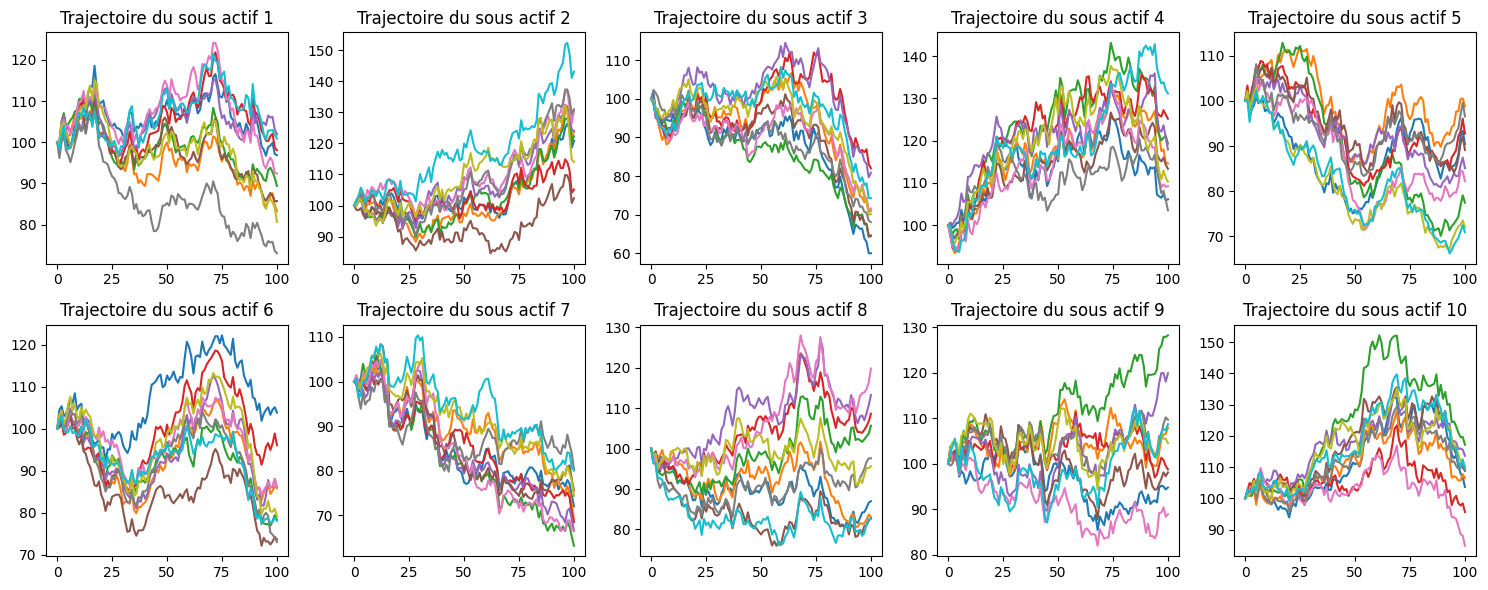

Monte Carlo price pour Basket Call Option: 9.51 (9.37, 9.66)
Monte Carlo price pour Asian Option: 5.23 (5.15, 5.31)
Monte Carlo price pour Digital Option: 54.65 (54.12, 55.19)
Monte Carlo price pour Worst Of Put Option: 12.66 (12.53, 12.79)


In [26]:
def heston_model(S0, K, T, r, kappa, sigma_0, a, nu, gamma, nb_trajectoires, nb_steps, d, rho, Z):
    dt = T / nb_steps

    Sigma= torch.full((d, d), rho) + (1 - rho) * torch.eye(d)
    L = torch.linalg.cholesky(Sigma)
    
    dB = torch.einsum('ijk,kl->ijl', torch.randn(Z.shape[0], Z.shape[1], Z.shape[2]), L.T)
    dB_tilde = torch.randn(Z.shape[0], Z.shape[1], Z.shape[2])
    
    S = torch.zeros((Z.shape[0], Z.shape[1], Z.shape[2]))
    S[:, 0, :] =  S0
    sigma = torch.ones((Z.shape[0], Z.shape[1], Z.shape[2])) * sigma_0
    # Calculer les trajectoires du modèle Heston
    for i in range(1, nb_steps + 1):
        dSi = r * S[:, i-1, :] * dt + torch.sqrt(sigma[:, i-1, :]) * S[:, i-1, :] * torch.sqrt(dt) * dB[:, i-1, :]
        dSigma_i = kappa * (a - sigma[:, i-1, :]) * dt + \
                    nu * torch.sqrt(sigma[:, i-1, :]) * \
                    (gamma * torch.sqrt(dt) * dB[:, i-1, :] + torch.sqrt(1 - gamma**2) * torch.sqrt(dt) * dB_tilde[:, i-1, :])
        S[:, i, :] = S[:, i-1, :] + dSi
        sigma[:, i, :] = sigma[:, i-1, :] + dSigma_i
    return S

#Modele d'Heston

# MC Heston
S_heston = heston_model(S0, K, T, r, kappa, sigma_0, a, nu, gamma, nb_trajectoires, nb_steps, d, rho, random_normale(nb_trajectoires, nb_steps, d)
)

# Payoff
basket_call_heston = basket_call_payoff(S_heston, weights, K)
asian_option_heston = asian_option_payoff(S_heston, weights, K)
digital_option_heston = digital_option_payoff(S_heston, weights, K)
worst_of_put_heston = worst_of_put_payoff(S_heston, weights, K)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

#On trace les différentes trajectoires du marché
for i, ax in enumerate(axes.flatten()):
    if i < nb_trajectoires:
        ax.plot(S_heston[i, :, :])
        ax.set_title(f'Trajectoire du sous actif {i + 1}')

plt.tight_layout()
plt.show()

printResults(basket_call_heston, asian_option_heston, digital_option_heston, worst_of_put_heston)

### First Approach Dimension reduction

In [7]:
class DimensionReductionNetwork(nn.Module):
  def __init__(self, input_dim, reduction_dim, output_dim):
    super(DimensionReductionNetwork, self).__init__()
    self.reduction_layer = nn.Linear(input_dim, reduction_dim, bias=False)
    self.reconstitution_layer = nn.Linear(reduction_dim, output_dim)

  def forward(self, x):
    z_tilde = self.reduction_layer(x)
    reconstructed_output = self.reconstitution_layer(torch.relu(z_tilde))
    return z_tilde

In [8]:
N = d

hyperparameters = {"prop_train_set" : 0.8, "input_size" : (nb_steps+1)*d
                              , "reduction_dim" : 100, "output_dim" : 1, "batch_size" : 32
                             , "nb_epochs" : 12, "lr" : 0.01}

In [9]:
input_size = hyperparameters["input_size"]
reduction_dim = hyperparameters["reduction_dim"]
output_dim = hyperparameters["output_dim"]

model_basket_call_dim = DimensionReductionNetwork(input_size, reduction_dim, output_dim)
model_digital_option_dim = DimensionReductionNetwork(input_size, reduction_dim, output_dim)
model_worst_of_put_dim = DimensionReductionNetwork(input_size, reduction_dim, output_dim)
model_asian_option_dim = DimensionReductionNetwork(input_size, reduction_dim, output_dim)

model_basket_call_dim.to(device)
model_digital_option_dim.to(device)
model_worst_of_put_dim.to(device)
model_asian_option_dim.to(device)

list_model = [model_basket_call_dim, model_digital_option_dim, model_worst_of_put_dim, model_asian_option_dim]

S = black_scholes_mc(S0, K, T, r, sigma, nb_trajectoires, nb_steps, d, rho, random_normale(nb_trajectoires, nb_steps, d))

Z = random_normale(nb_trajectoires, nb_steps, d)
Propotion_X_train = int(hyperparameters["prop_train_set"]*Z.shape[0])
X_train = Z[:Propotion_X_train,:,:]
X_test = Z[Propotion_X_train:,:,:]
S_train = black_scholes_mc(S0 , K, T, r, sigma, nb_trajectoires, nb_steps, d, rho, X_train)
S_test = black_scholes_mc(S0 , K, T, r, sigma, nb_trajectoires, nb_steps, d, rho, X_test)
y_train = basket_call_payoff(S_train, weights, K)
y_test = basket_call_payoff(S_test, weights, K)

X_train = X_train.view(X_train.shape[0], -1)
y_train = y_train.view(y_train.shape[0], 1)

X_test = X_test.view(X_test.shape[0], -1)
y_test = y_test.view(y_test.shape[0], 1)

print("X_train dim", X_train.shape)
print("y_train dim", y_train.shape)
print("X_test dim", X_test.shape)
print("y_test dim", y_test.shape)
#Entrainement du modèle
def train(model, hyperparameters):

    
    nb_epochs = hyperparameters["nb_epochs"]
    lr = hyperparameters["lr"]
    
    criterion = nn.MSELoss()
    
    optimizer = optim.Adam(model.parameters(), lr)
    
    for epoch in tqdm(range(nb_epochs)):
        model.train()

        y_pred = model(X_train)

        loss = criterion(y_pred, y_train)
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        model_basket_call_dim.eval()
        with torch.inference_mode():
            test_pred = model(X_test)
            test_loss = criterion(test_pred, y_test)
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

X_train dim torch.Size([24000, 1010])
y_train dim torch.Size([24000, 1])
X_test dim torch.Size([6000, 1010])
y_test dim torch.Size([6000, 1])


In [10]:
train(model_basket_call_dim, hyperparameters)

  0%|                                                                                           | 0/12 [00:00<?, ?it/s]C:\Users\aissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([24000, 1])) that is different to the input size (torch.Size([24000, 100])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\aissa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([6000, 1])) that is different to the input size (torch.Size([6000, 100])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  8%|██████▉                                                                            | 1/12 [00:00<00:

Epoch: 0 | Loss: 975.9227905273438 | Test loss: 961.3461303710938


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [00:03<00:00,  3.14it/s]

Epoch: 10 | Loss: 889.8980712890625 | Test loss: 892.4078979492188


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.86it/s]


In [11]:
# Obtenir la matrice U normalisée

Z = torch.randn(nb_trajectoires, N)

#def basisKernel(U):
    n, N = U.shape
    I = torch.eye(N)
    matrice_augmentee = torch.cat((U, I), dim=0)
    matrice_augmentee = Matrix(matrice_augmentee)
    return matrice_augmentee.nullspace()

list_model = [model_basket_call_dim]

for model in list_model:
    U_normalisee = model.reduction_layer.weight.data / torch.norm(model.reduction_layer.weight.data, dim=1, keepdim=True)
    V = basisKernel(U_normalisee)
    print("V", V)
    print("V DIM : ", len(V))
    print("U_normalisee", U_normalisee.T.shape)
    #Erreur on devrait trouver V de dimension N-n*N
    Z_reduit = torch.matmul(Z, U_normalisee.T)

    # Simulation de Z_orthogonal
    Z_orthogonal = torch.matmul(Z, V.T)
    M=torch.cat((U_normalisee, V), dim=0)
print(V.shape)
print(U_normalisee.shape)

IndentationError: unexpected indent (28182577.py, line 6)

In [12]:
A = np.array([[1,1,1,1],[2,1,4,3],[3,4,1,2]])
A = Matrix(A)
nullspace = A.nullspace()
nullspace_tensors = [torch.tensor(v.tolist(), dtype=torch.float64) for v in nullspace]

print(nullspace_tensors)

[tensor([[-3.],
        [ 2.],
        [ 1.],
        [ 0.]], dtype=torch.float64), tensor([[-2.],
        [ 1.],
        [ 0.],
        [ 1.]], dtype=torch.float64)]


In [13]:
#Cette partie est la plus importante
## Hyper paramètres

hyperparameters = {"perc_train_set" : 0.8, "input_size" : (nb_steps+1)*d
                              , "hidden_size" : 64, "output_size" : 1, "batch_size" : 32
                             , "nb_epochs" : 32, "lr" : 0.001}

In [14]:
#Création des différents modèles
class NeuralNetwork_Analytic_Integration(nn.Module):
    def __init__(self, input_size, hidden_size1, output_size):
        super(NeuralNetwork_Analytic_Integration, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size1, output_size)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x

model_bs_names = ["model_bs_basket_call", "model_bs_digital_option", 
                  "model_bs_worst_of_put", "model_bs_asian_option",]

model_vol_names = ["model_vol_basket_call", "model_vol_digital_option", 
                   "model_vol_worst_of_put", "model_vol_asian_option"]
    
model_heston_names = ["model_heston_basket_call", "model_heston_digital_option", 
                      "model_heston_worst_of_put", "model_heston_asian_option"]

model_bs = {}
model_vol = {}
model_heston = {}

for name in model_bs_names:
    model_bs[name]= NeuralNetwork_Analytic_Integration(hyperparameters['input_size'], 
                                                    hyperparameters['hidden_size'], hyperparameters['output_size']).to(device)
for name in model_vol_names:
    model_vol[name]= NeuralNetwork_Analytic_Integration(hyperparameters['input_size'], 
                                                    hyperparameters['hidden_size'], hyperparameters['output_size']).to(device)
for name in model_heston_names:
    model_heston[name]= NeuralNetwork_Analytic_Integration(hyperparameters['input_size'], 
                                                    hyperparameters['hidden_size'], hyperparameters['output_size']).to(device)

In [15]:
def train(list_model, diffusion_model, X, hyperparameters): #Train devrait prendre juste trainset et testset en paramètres avec un dictionnaire
    
    perc_train_set = hyperparameters["perc_train_set"]
    prop_train_set = int(perc_train_set*nb_trajectoires)
    nb_epochs = hyperparameters["nb_epochs"]
    batch_size = hyperparameters["batch_size"]
    lr = hyperparameters["lr"]

    if diffusion_model == 'bs':
        S = black_scholes_mc(S0 , K, T, r, sigma, nb_trajectoires, nb_steps, d, rho, X)
    elif diffusion_model == 'loc_vol':
        S = volatilite_locale(S0 , K, T, r, sigma, nb_trajectoires, nb_steps, d, rho, X)
    else:
        S = heston_model(S0, K, T, r, kappa, sigma_0, a, nu, gamma, nb_trajectoires, nb_steps, d, rho, X)

    X_train = X[:prop_train_set, :, :]
    X_test = X[prop_train_set:, :, :]
        
    for (i,model) in enumerate(list_model_bs):
        if i == 0:
            y = basket_call_payoff(S, weights, K)
        elif i == 1:
            y = digital_option_payoff(S, weights, K)
        elif i == 2:
            y = worst_of_put_payoff(S, weights, K)
        else:
            y = asian_option_payoff(S, weights, K)

        y_train = y[:prop_train_set]
        y_test = y[prop_train_set:]
        
        X_train = X_train.view(X_train.shape[0], -1)
        X_test = X_test.view(X_test.shape[0], -1)
        
        y_train = y_train.view(y_train.shape[0], 1)
        y_test = y_test.view(y_test.shape[0], 1)
        
        train_dataset = TensorDataset(X_train, y_train)
        test_dataset = TensorDataset(X_test, y_test)
    
        train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=True)
    
        optimizer = torch.optim.Adam(model.parameters(), lr)
    
        criterion = torch.nn.MSELoss()
        
        #print('X_train', X_train.shape)
        #print('X_test', X_test.shape)
        #print('y_train', y_train.shape)
        #print('y_test', y_test.shape)
        
        train_loss = []
        test_loss = []
        
        for epoch in tqdm(range(nb_epochs)):
            model.train()
            train_losses = []
            
            for inputs, targets in train_loader:
                #inputs, targets = inputs.to(device), targets.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                train_losses.append(loss.item())
    
            train_loss.append(sum(train_losses) / len(train_losses))
            
            if epoch % 10 == 0:
                model.eval()
                test_losses = []
               
                with torch.no_grad():
                    for inputs, targets in test_loader:
                        #inputs, targets = inputs.to(device), targets.to(device)
                        outputs = model(inputs)
                        loss_test = criterion(outputs, targets)
                        test_losses.append(loss_test.item())
                        
                test_loss.append(sum(test_losses) / len(test_losses))
                print(f"Epoch: {epoch} | Train Loss: {train_loss[-1]} | Test Loss: {test_loss[-1]}")
        
        plt.plot(range(len(test_loss)),test_loss, label=f'Modèle {i}')

  3%|██▌                                                                                | 1/32 [00:02<01:30,  2.93s/it]

Epoch: 0 | Train Loss: 328.6256704915365 | Test Loss: 42.14514659820719


 34%|████████████████████████████▏                                                     | 11/32 [00:28<00:52,  2.48s/it]

Epoch: 10 | Train Loss: 6.957524652798971 | Test Loss: 10.025066879201443


 66%|█████████████████████████████████████████████████████▊                            | 21/32 [00:56<00:34,  3.18s/it]

Epoch: 20 | Train Loss: 3.2335531407197315 | Test Loss: 7.316045759840215


 97%|███████████████████████████████████████████████████████████████████████████████▍  | 31/32 [01:28<00:03,  3.25s/it]

Epoch: 30 | Train Loss: 1.9562804496884345 | Test Loss: 7.097986537091275


  3%|██▌                                                                                | 1/32 [00:03<01:43,  3.34s/it]

Epoch: 0 | Train Loss: 2214.0354403483075 | Test Loss: 957.4416051012405


 34%|████████████████████████████▏                                                     | 11/32 [00:35<01:12,  3.43s/it]

Epoch: 10 | Train Loss: 617.3106400960287 | Test Loss: 998.6219660982173


 66%|█████████████████████████████████████████████████████▊                            | 21/32 [01:08<00:37,  3.37s/it]

Epoch: 20 | Train Loss: 370.0674211222331 | Test Loss: 1097.0919770585729


 97%|███████████████████████████████████████████████████████████████████████████████▍  | 31/32 [01:41<00:03,  3.34s/it]

Epoch: 30 | Train Loss: 166.93827998860678 | Test Loss: 1206.8129741587538


  3%|██▌                                                                                | 1/32 [00:03<01:50,  3.55s/it]

Epoch: 0 | Train Loss: 343.0491758626302 | Test Loss: 67.01418412999904


 34%|████████████████████████████▏                                                     | 11/32 [00:34<01:04,  3.06s/it]

Epoch: 10 | Train Loss: 20.9290881245931 | Test Loss: 68.69984391395082


 66%|█████████████████████████████████████████████████████▊                            | 21/32 [01:05<00:35,  3.23s/it]

Epoch: 20 | Train Loss: 6.658179122924805 | Test Loss: 76.42595234323055


 97%|███████████████████████████████████████████████████████████████████████████████▍  | 31/32 [01:34<00:02,  2.90s/it]

Epoch: 30 | Train Loss: 3.0162018263339996 | Test Loss: 79.23967709439866


  3%|██▌                                                                                | 1/32 [00:03<01:36,  3.11s/it]

Epoch: 0 | Train Loss: 75.04397485208511 | Test Loss: 6.045518508616914


 34%|████████████████████████████▏                                                     | 11/32 [00:31<00:59,  2.82s/it]

Epoch: 10 | Train Loss: 1.474126440425714 | Test Loss: 2.1534490407781397


 66%|█████████████████████████████████████████████████████▊                            | 21/32 [01:02<00:34,  3.17s/it]

Epoch: 20 | Train Loss: 0.7435030840337277 | Test Loss: 1.95085978634814


 97%|███████████████████████████████████████████████████████████████████████████████▍  | 31/32 [01:30<00:02,  2.84s/it]

Epoch: 30 | Train Loss: 0.49752188857396445 | Test Loss: 1.4204753602438784


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [01:33<00:00,  2.91s/it]


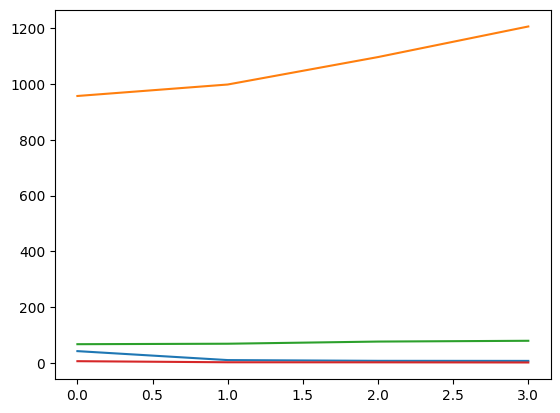

In [16]:
#Entrainement des modèles dont les actifs suivent le modèle de Black Scholes

model_bs_basket_call = model_bs["model_bs_basket_call"]
model_bs_digital_option = model_bs["model_bs_digital_option"]
model_bs_worst_of_put = model_bs["model_bs_worst_of_put"]
model_bs_asian_option = model_bs["model_bs_asian_option"]

list_model_bs = [model_bs_basket_call, model_bs_digital_option, 
                 model_bs_worst_of_put, model_bs_asian_option]

train(list_model_bs, 'bs', random_normale(nb_trajectoires, nb_steps, d), hyperparameters)

In [28]:
#Cette cellule sert à calculer l'espérance du modèle directement en fonction des paramètres
def Analytic_integration(model):
    params = model.state_dict()
    W1 = params['layer1.weight']
    b1 = params['layer1.bias']
    W2 = params['layer2.weight']
    b2 = params['layer2.bias']

    sigma = torch.sum(W1**2, dim=1)
    mu = b1
    cdf_result = torch.tensor(norm.cdf((-mu/(torch.sqrt(sigma))).cpu().numpy(), 0, 1)).to(device)

    expression = (torch.sqrt(sigma)) / (torch.sqrt(2 * torch.tensor(torch.pi))) * \
    torch.exp(- mu**2/ (2 * sigma)) + mu * (1 - cdf_result)

    expression = expression.unsqueeze(1)
    W2 = W2.to(expression.dtype)

    esperance = torch.mm(W2, expression) + b2
    return esperance.to(device)

        #Cette cellule sert à calculer l'espérance du modèle directement en fonction des paramètres
def Analytic_integration(model):
    params = model.state_dict()
    W1 = params['layer1.weight']
    b1 = params['layer1.bias']
    W2 = params['layer2.weight']
    b2 = params['layer2.bias']

    sigma = torch.sum(W1**2, dim=1)
    mu = b1
    cdf_result = torch.tensor(norm.cdf((-mu/(torch.sqrt(sigma))).cpu().numpy(), 0, 1)).to(device)

    expression = (torch.sqrt(sigma)) / (torch.sqrt(2 * torch.tensor(torch.pi))) * \
    torch.exp(- mu**2/ (2 * sigma)) + mu * (1 - cdf_result)

    expression = expression.unsqueeze(1)
    W2 = W2.to(expression.dtype)

    esperance = torch.mm(W2, expression) + b2
    return esperance.to(device)

# Y = f(Z) - H(Z) +E[H(Z)], E[Y] = E[f(Z)]
def Y(model, diffusion_model, payoff,new_Z):
    liste = []
    model.eval()
    for i in range(500):
        Z_trajectory = new_Z[i,:,:]
        Z_trajectory = Z_trajectory.view(1,nb_steps+1,d)
        if diffusion_model == 'bs':
            random_S = black_scholes_mc(S0 , K, T, r, sigma, nb_trajectoires, nb_steps, d, rho, Z_trajectory)
        elif diffusion_model == 'loc_vol':
            random_S = volatilite_locale(S0 , K, T, r, sigma, nb_trajectoires, nb_steps, d, rho, Z_trajectory)
        else:
            random_S = heston_model(S0 , K, T, r, sigma, nb_trajectoires, nb_steps, d, rho, Z_trajectory)
        f_Z = payoff(random_S, weights, K)
        Z_trajectory = Z_trajectory.flatten().reshape(1,-1)
        Z_trajectory = Z_trajectory.to(device)
        Y = f_Z - model(Z_trajectory).item() + Analytic_integration(model).item()
        liste.append(Y)
    liste = torch.tensor(liste) #extand le tensor ?
    print(torch.mean(liste).item())

In [18]:
#Testons maintenant la méthode 2 avec Black Scholes
#Nous comparons les payoff obtenus pour une trajectoire de l'actif avec le modèle et avec la fonction du payoff

perc_train_set = hyperparameters["perc_train_set"]

random_number = np.random.randint(nb_trajectoires*perc_train_set,nb_trajectoires)

Z = random_normale(nb_trajectoires, nb_steps, d)

print("trajectoire numero " + str(random_number))
random_Z = Z[random_number,: ,:]

random_Z = random_Z.reshape(1, nb_steps+1, d)

random_S = black_scholes_mc(S0 , K, T, r, sigma, nb_trajectoires, nb_steps, d, rho, random_Z)

#Evaluation du payoff de la trajectoire avec les fonctions payoff
print("Payoff Call Basket | output : ", basket_call_payoff(random_S, weights, K).item())
print("Payoff Digital Option | output : ", digital_option_payoff(random_S, weights, K).item())
print("Payoff Put Worst of max | output : ", worst_of_put_payoff(random_S, weights, K).item())
print("Payoff Arithmetic Asian | output : ", asian_option_payoff(random_S, weights, K).item())

print()
random_Z = random_Z.reshape(1, -1)
random_Z = random_Z.to(device)

#Evaluation du payoff de la trajectoire avec les modèles
for model_name, model_instance in model_bs.items():
    model_instance.eval()
    output = model_instance(random_Z).item()
    print(f"Model {model_name} | output : ", output)

trajectoire numero 28883
Payoff Call Basket | output :  28.470291137695312
Payoff Digital Option | output :  95.1229476928711
Payoff Put Worst of max | output :  2.84870982170105
Payoff Arithmetic Asian | output :  29.256025314331055

Model model_bs_basket_call | output :  24.362640380859375
Model model_bs_digital_option | output :  45.14339065551758
Model model_bs_worst_of_put | output :  7.047587871551514
Model model_bs_asian_option | output :  30.151357650756836


In [19]:
dic_model_bs_payoff = {model_bs_basket_call : basket_call_payoff, model_bs_digital_option : digital_option_payoff,
                     model_bs_worst_of_put : worst_of_put_payoff, model_bs_asian_option : asian_option_payoff}

new_Z = random_normale(nb_trajectoires, nb_steps, d)
#Les prix obtenues sont ceux du tableau 2
for model,payoff in dic_model_bs_payoff.items():
  Y(model,'bs', payoff, new_Z)

16.269498825073242
47.165016174316406
26.48874855041504
9.110222816467285


  3%|██▌                                                                                | 1/32 [00:03<01:42,  3.29s/it]

Epoch: 0 | Train Loss: 82.48659956995647 | Test Loss: 83.01531570515733


 34%|████████████████████████████▏                                                     | 11/32 [00:31<01:00,  2.87s/it]

Epoch: 10 | Train Loss: 6.9505526514848075 | Test Loss: 54.34676872542564


 66%|█████████████████████████████████████████████████████▊                            | 21/32 [01:03<00:33,  3.03s/it]

Epoch: 20 | Train Loss: 3.607329556941986 | Test Loss: 52.20747888341863


 97%|███████████████████████████████████████████████████████████████████████████████▍  | 31/32 [01:32<00:03,  3.01s/it]

Epoch: 30 | Train Loss: 3.1300594561497372 | Test Loss: 52.196093640428906


  3%|██▌                                                                                | 1/32 [00:03<01:38,  3.17s/it]

Epoch: 0 | Train Loss: 1282.051910563151 | Test Loss: 1195.769509173454


 34%|████████████████████████████▏                                                     | 11/32 [00:37<01:13,  3.48s/it]

Epoch: 10 | Train Loss: 169.18926568603516 | Test Loss: 1253.0942937972698


 66%|█████████████████████████████████████████████████████▊                            | 21/32 [01:09<00:34,  3.17s/it]

Epoch: 20 | Train Loss: 31.010877058664956 | Test Loss: 1370.9598836695893


 97%|███████████████████████████████████████████████████████████████████████████████▍  | 31/32 [01:41<00:03,  3.19s/it]

Epoch: 30 | Train Loss: 24.843292605082194 | Test Loss: 1369.8914785182221


  3%|██▌                                                                                | 1/32 [00:03<01:44,  3.36s/it]

Epoch: 0 | Train Loss: 56.05602278900147 | Test Loss: 29.891973074446334


 34%|████████████████████████████▏                                                     | 11/32 [00:35<01:07,  3.22s/it]

Epoch: 10 | Train Loss: 3.0869386076132455 | Test Loss: 28.559175141314242


 66%|█████████████████████████████████████████████████████▊                            | 21/32 [01:06<00:33,  3.08s/it]

Epoch: 20 | Train Loss: 1.227960257848104 | Test Loss: 28.18339854098381


 97%|███████████████████████████████████████████████████████████████████████████████▍  | 31/32 [01:36<00:02,  2.96s/it]

Epoch: 30 | Train Loss: 0.8685408583084743 | Test Loss: 27.527762636225273


  3%|██▌                                                                                | 1/32 [00:03<01:41,  3.26s/it]

Epoch: 0 | Train Loss: 12.073756977915764 | Test Loss: 8.184605634592948


 34%|████████████████████████████▏                                                     | 11/32 [00:33<01:05,  3.11s/it]

Epoch: 10 | Train Loss: 0.8688017600476742 | Test Loss: 6.439912815360313


 66%|█████████████████████████████████████████████████████▊                            | 21/32 [01:04<00:33,  3.07s/it]

Epoch: 20 | Train Loss: 0.5264403916696707 | Test Loss: 5.856012331678512


 97%|███████████████████████████████████████████████████████████████████████████████▍  | 31/32 [01:34<00:03,  3.07s/it]

Epoch: 30 | Train Loss: 0.47524025711913903 | Test Loss: 5.891300624355357


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [01:37<00:00,  3.04s/it]


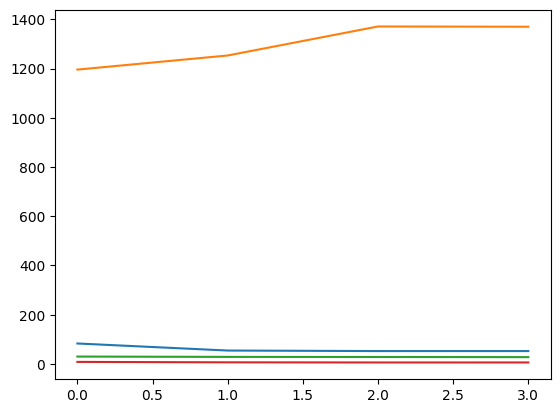

In [20]:
#Entrainement des modèles dont les actifs suivent le modèle vol locale

model_vol_basket_call = model_vol["model_vol_basket_call"]
model_vol_digital_option = model_vol["model_vol_digital_option"]
model_vol_worst_of_put = model_vol["model_vol_worst_of_put"]
model_vol_asian_option = model_vol["model_vol_asian_option"]

list_model_vol = [model_vol_basket_call, model_vol_digital_option, 
                  model_vol_worst_of_put, model_vol_asian_option]

train(list_model_vol, 'loc_vol', random_normale(nb_trajectoires, nb_steps, d), hyperparameters)

In [21]:
#Testons maintenant la méthode 2 avec Black Scholes
#Nous comparons les payoff obtenus pour une trajectoire de l'actif avec le modèle et avec la fonction du payoff

perc_train_set = hyperparameters["perc_train_set"]

random_number = np.random.randint(nb_trajectoires*perc_train_set,nb_trajectoires)

Z = random_normale(nb_trajectoires, nb_steps, d)

print("trajectoire numero " + str(random_number))
random_Z = Z[random_number,: ,:]

random_Z = random_Z.reshape(1, nb_steps+1, d)

random_S = volatilite_locale(S0, K, T, r, sigma, nb_trajectoires, nb_steps, d, rho, random_Z)

#Evaluation du payoff de la trajectoire avec les fonctions payoff
print("Payoff Call Basket | output : ", basket_call_payoff(random_S, weights, K).item())
print("Payoff Digital Option | output : ", digital_option_payoff(random_S, weights, K).item())
print("Payoff Put Worst of max | output : ", worst_of_put_payoff(random_S, weights, K).item())
print("Payoff Arithmetic Asian | output : ", asian_option_payoff(random_S, weights, K).item())

print()
random_Z = random_Z.reshape(1, -1)
random_Z = random_Z.to(device)

#Evaluation du payoff de la trajectoire avec les modèles
for model_name, model_instance in model_vol.items():
    model_instance.eval()
    output = model_instance(random_Z).item()
    print(f"Model {model_name} | output : ", output)

trajectoire numero 27944
Payoff Call Basket | output :  3.2054498195648193
Payoff Digital Option | output :  95.1229476928711
Payoff Put Worst of max | output :  7.526550769805908
Payoff Arithmetic Asian | output :  0.7231251001358032

Model model_vol_basket_call | output :  0.31726181507110596
Model model_vol_digital_option | output :  -0.21941006183624268
Model model_vol_worst_of_put | output :  0.3516806364059448
Model model_vol_asian_option | output :  0.17223313450813293


In [22]:
dic_model_vol_payoff = {model_vol_basket_call : basket_call_payoff, model_vol_digital_option : digital_option_payoff,
                     model_vol_worst_of_put : worst_of_put_payoff, model_vol_asian_option : asian_option_payoff}

#Entrainement des modèles dont les actifs suivent le modèle vol locale

new_Z = random_normale(nb_trajectoires, nb_steps, d)
#Les prix obtenues sont ceux du tableau 2
for model,payoff in dic_model_vol_payoff.items():
  Y(model,'loc_vol', payoff,new_Z)

8.58344841003418
48.14283752441406
11.003484725952148
4.315854549407959


  3%|██▌                                                                                | 1/32 [00:03<01:51,  3.58s/it]

Epoch: 0 | Train Loss: 263.4100734710693 | Test Loss: 200.90585079598935


 34%|████████████████████████████▏                                                     | 11/32 [00:35<01:08,  3.25s/it]

Epoch: 10 | Train Loss: 38.71438479105632 | Test Loss: 241.6467708831138


 66%|█████████████████████████████████████████████████████▊                            | 21/32 [01:06<00:42,  3.88s/it]

Epoch: 20 | Train Loss: 12.059798697471619 | Test Loss: 275.0044826345241


 97%|███████████████████████████████████████████████████████████████████████████████▍  | 31/32 [01:35<00:03,  3.01s/it]

Epoch: 30 | Train Loss: 7.672800366401672 | Test Loss: 283.53305865348653


  3%|██▌                                                                                | 1/32 [00:02<01:28,  2.85s/it]

Epoch: 0 | Train Loss: 3301.474427571615 | Test Loss: 2836.383695561835


 34%|████████████████████████████▏                                                     | 11/32 [00:32<01:00,  2.87s/it]

Epoch: 10 | Train Loss: 444.2061367594401 | Test Loss: 3024.0699449904423


 66%|█████████████████████████████████████████████████████▊                            | 21/32 [01:00<00:31,  2.83s/it]

Epoch: 20 | Train Loss: 56.88120027414958 | Test Loss: 3529.5911969124004


 97%|███████████████████████████████████████████████████████████████████████████████▍  | 31/32 [01:27<00:02,  2.53s/it]

Epoch: 30 | Train Loss: 50.183469757080076 | Test Loss: 3536.5753264731547


  3%|██▌                                                                                | 1/32 [00:02<01:07,  2.17s/it]

Epoch: 0 | Train Loss: 192.25165320841472 | Test Loss: 159.12872265754862


 34%|████████████████████████████▏                                                     | 11/32 [00:27<00:57,  2.73s/it]

Epoch: 10 | Train Loss: 20.05019944381714 | Test Loss: 190.52143738117624


 66%|█████████████████████████████████████████████████████▊                            | 21/32 [00:57<00:34,  3.18s/it]

Epoch: 20 | Train Loss: 4.0455807426770525 | Test Loss: 216.1677112173527


 97%|███████████████████████████████████████████████████████████████████████████████▍  | 31/32 [01:26<00:02,  2.98s/it]

Epoch: 30 | Train Loss: 3.070496212800344 | Test Loss: 208.79156173543728


  3%|██▌                                                                                | 1/32 [00:03<01:44,  3.36s/it]

Epoch: 0 | Train Loss: 62.23050044631958 | Test Loss: 55.233402313070094


 34%|████████████████████████████▏                                                     | 11/32 [00:31<00:59,  2.83s/it]

Epoch: 10 | Train Loss: 8.549453997294108 | Test Loss: 77.45272543075237


 66%|█████████████████████████████████████████████████████▊                            | 21/32 [01:00<00:32,  2.97s/it]

Epoch: 20 | Train Loss: 3.3672718335787457 | Test Loss: 84.48171583135077


 97%|███████████████████████████████████████████████████████████████████████████████▍  | 31/32 [01:29<00:02,  2.88s/it]

Epoch: 30 | Train Loss: 2.3728357748190563 | Test Loss: 85.86394137524545


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [01:32<00:00,  2.88s/it]


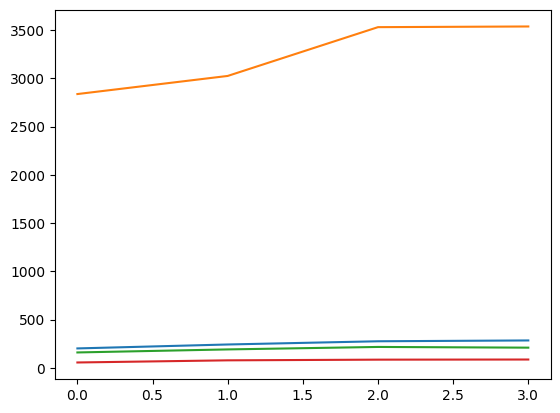

In [23]:
#Dans cette cellule nous comparons les payoff pour une trajectoire de l'actif entre le modèle et la fonction du payoff

model_heston_basket_call = model_heston["model_heston_basket_call"]
model_heston_digital_option = model_heston["model_heston_digital_option"]
model_heston_worst_of_put = model_heston["model_heston_worst_of_put"]
model_heston_asian_option = model_heston["model_heston_asian_option"]

list_model_heston = [model_heston_basket_call, model_heston_digital_option, model_heston_worst_of_put, model_heston_asian_option]

train(list_model_vol, 'heston', random_normale(nb_trajectoires, nb_steps, d), hyperparameters)

In [24]:
#Testons maintenant la méthode 2 avec Black Scholes
#Nous comparons les payoff obtenus pour une trajectoire de l'actif avec le modèle et avec la fonction du payoff

perc_train_set = hyperparameters["perc_train_set"]

random_number = np.random.randint(nb_trajectoires*perc_train_set,nb_trajectoires)

Z = random_normale(nb_trajectoires, nb_steps, d)

print("trajectoire numero " + str(random_number))
random_Z = Z[random_number,: ,:]

random_Z = random_Z.reshape(1, nb_steps+1, d)

random_S = heston_model(S0, K, T, r, kappa, sigma_0, a, nu, gamma, nb_trajectoires, nb_steps, d, rho, random_Z)

#Evaluation du payoff de la trajectoire avec les fonctions payoff
print("Payoff Call Basket | output : ", basket_call_payoff(random_S, weights, K).item())
print("Payoff Digital Option | output : ", digital_option_payoff(random_S, weights, K).item())
print("Payoff Put Worst of max | output : ", worst_of_put_payoff(random_S, weights, K).item())
print("Payoff Arithmetic Asian | output : ", asian_option_payoff(random_S, weights, K).item())

print()
random_Z = random_Z.reshape(1, -1)
random_Z = random_Z.to(device)

#Evaluation du payoff de la trajectoire avec les modèles
for model_name, model_instance in model_heston.items():
    model_instance.eval()
    output = model_instance(random_Z).item()
    print(f"Model {model_name} | output : ", output)

trajectoire numero 27191


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1957.76it/s]

Payoff Call Basket | output :  11.115571022033691
Payoff Digital Option | output :  95.1229476928711
Payoff Put Worst of max | output :  8.819243431091309
Payoff Arithmetic Asian | output :  3.111663818359375

Model model_heston_basket_call | output :  0.04333430528640747
Model model_heston_digital_option | output :  -0.21782295405864716
Model model_heston_worst_of_put | output :  -0.07188034057617188
Model model_heston_asian_option | output :  0.2005809098482132


In [29]:
dic_model_heston_payoff = {model_heston_basket_call : basket_call_payoff, model_heston_digital_option : digital_option_payoff,
                     model_heston_worst_of_put : worst_of_put_payoff, model_heston_asian_option : asian_option_payoff}

new_Z = random_normale(nb_trajectoires, nb_steps, d)

def Y(model,payoff,new_Z):
  liste = []
  model.eval()
  for i in range(500):
    Z_trajectory = new_Z[i,:,:]
    Z_trajectory = Z_trajectory.view(1,nb_steps+1,d)
    random_S = heston_model(S0, K, T, r, kappa, sigma_0, a, nu, gamma, nb_trajectoires, nb_steps, d, rho, Z_trajectory)
    f_Z = payoff(random_S, weights, K)
    Z_trajectory = Z_trajectory.flatten().reshape(1,-1)
    Z_trajectory = Z_trajectory.to(device)
    Y = f_Z - model(Z_trajectory).item() + Analytic_integration(model).item()
    liste.append(Y)
  liste = torch.tensor(liste)
  print(torch.mean(liste))

#Prix proches de ceux du tableau 6
for model,payoff in dic_model_heston_payoff.items():
  Y(model,payoff,new_Z)

tensor(9.3184)
tensor(50.5866)
tensor(12.3841)
tensor(5.0647)
